<Axes: >

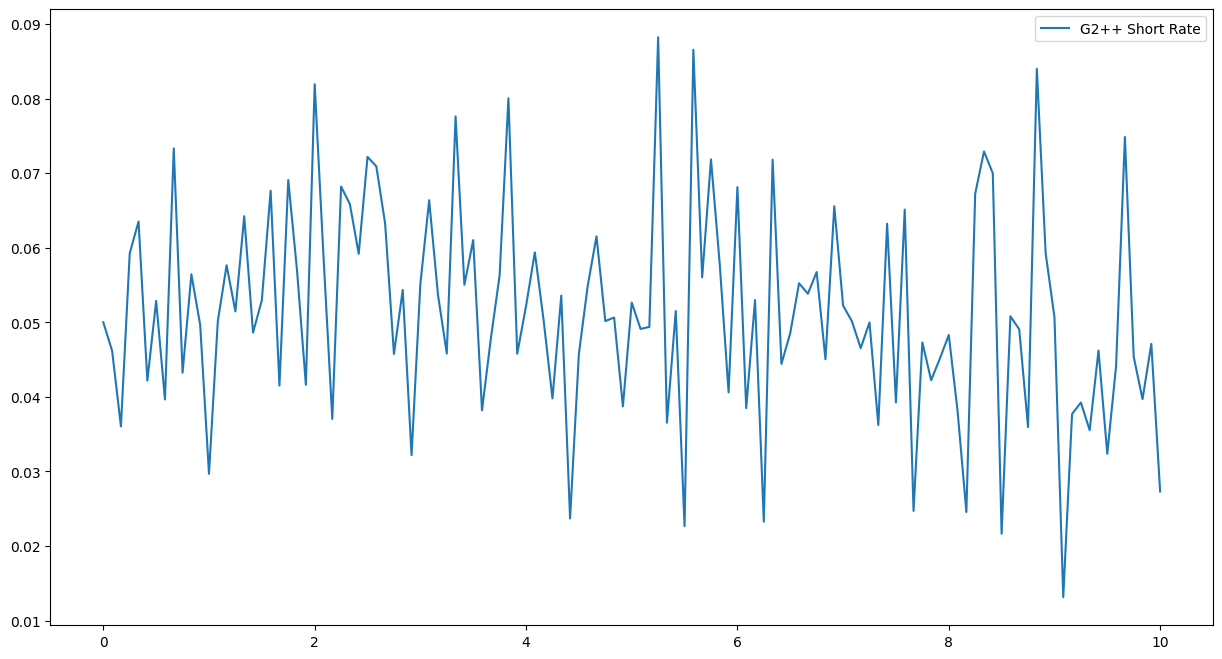

In [1]:
from dynamics import *
import seaborn as sns
import matplotlib.pyplot as plt
#Vasicek model
g2pp = G2PP(
    initial =0.05, 
    a       =1.1664,
    b       =0.0304,
    sigma   =0.0501,
    eta     =0.0084,
    rho     =-1.000)
time, rate = g2pp.create_path(stepsize=1/12, duration=10, seed=1999)
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=rate, label="G2++ Short Rate")


<Axes: >

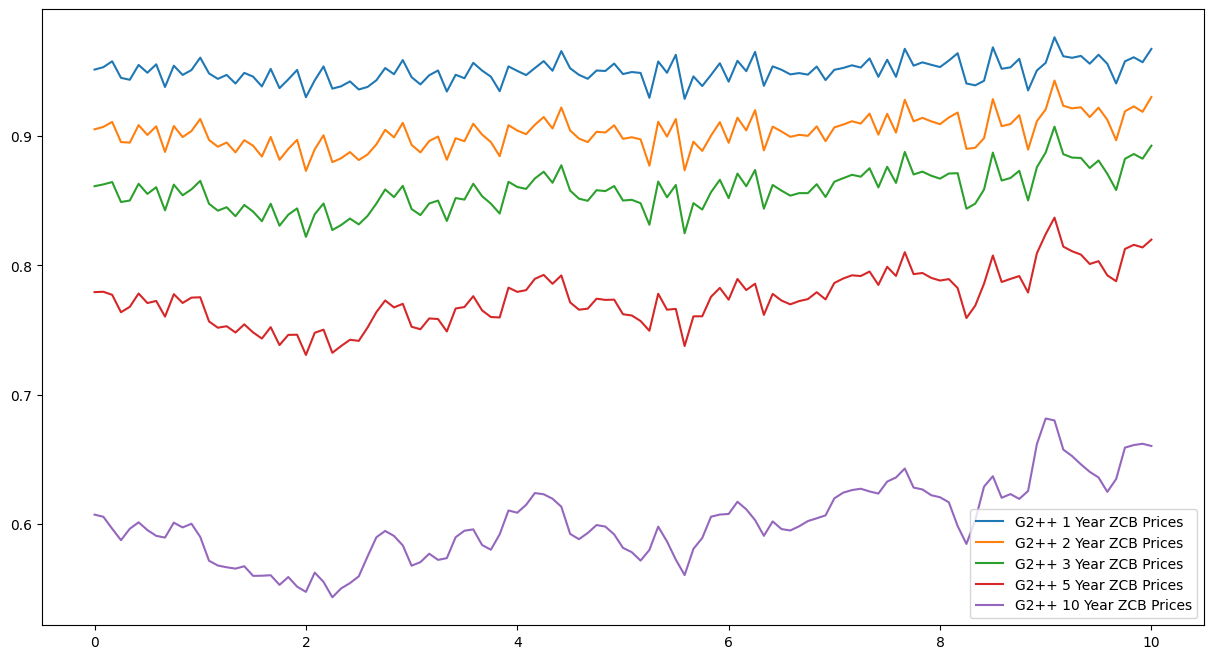

In [2]:
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=[g2pp.ZCB(duration=1, time=t) for t in time], label = "G2++ 1 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(duration=2, time=t) for t in time], label = "G2++ 2 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(duration=3, time=t) for t in time], label = "G2++ 3 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(duration=5, time=t) for t in time], label = "G2++ 5 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(duration=10,time=t) for t in time], label = "G2++ 10 Year ZCB Prices")

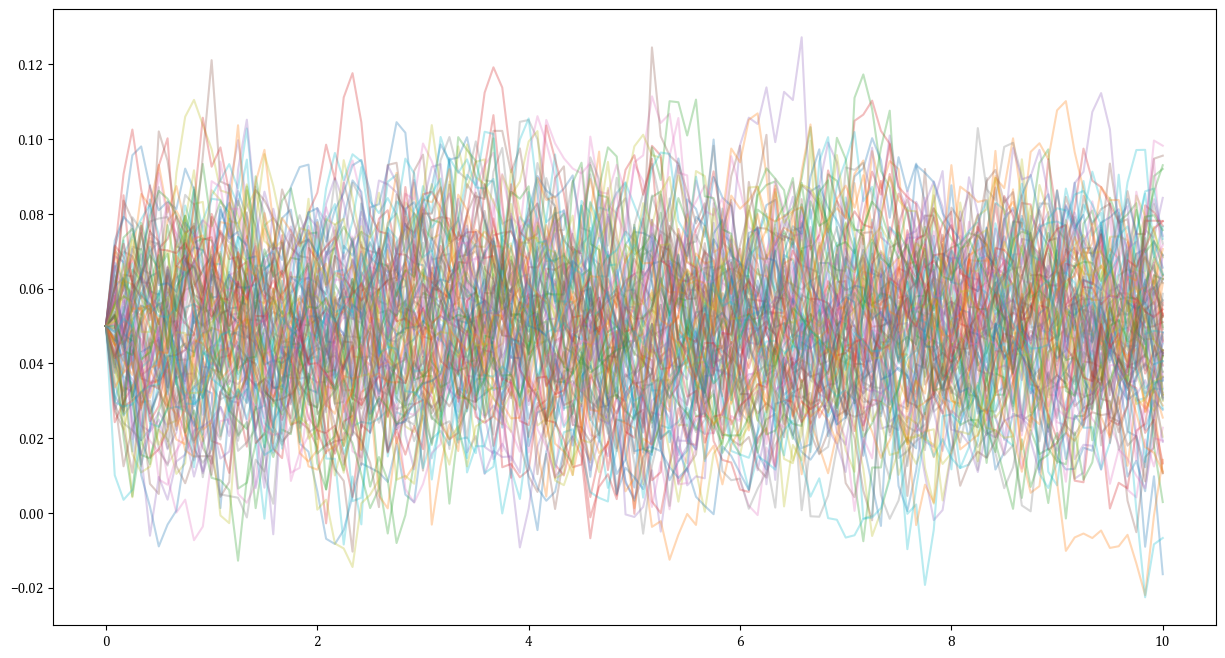

In [25]:
plt.figure(figsize=(15,8))
for i in range(100):
    time, rate = g2pp.create_path(stepsize=1/12, duration=10, seed=i)
    sns.lineplot(x=time, y=rate, alpha=0.3)
# sns.lineplot(x=time, y=expected, label="Vasicek Expected Short Rate", c='red')

<Axes: xlabel='Expiry'>

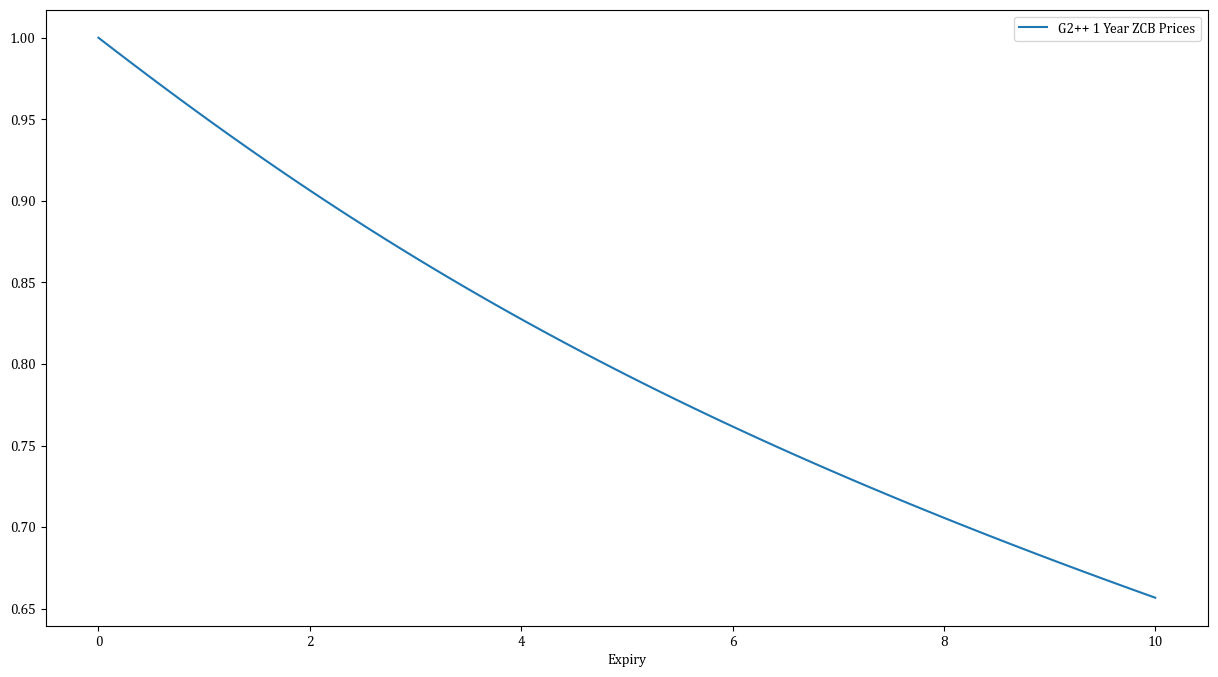

In [26]:
plt.figure(figsize=(15,8))
plt.xlabel("Expiry")
sns.lineplot(x=time, y=[g2pp.ZCB(duration=t,time=0, initRate=0.05) for t in time], label = "G2++ 1 Year ZCB Prices")

<Axes: >

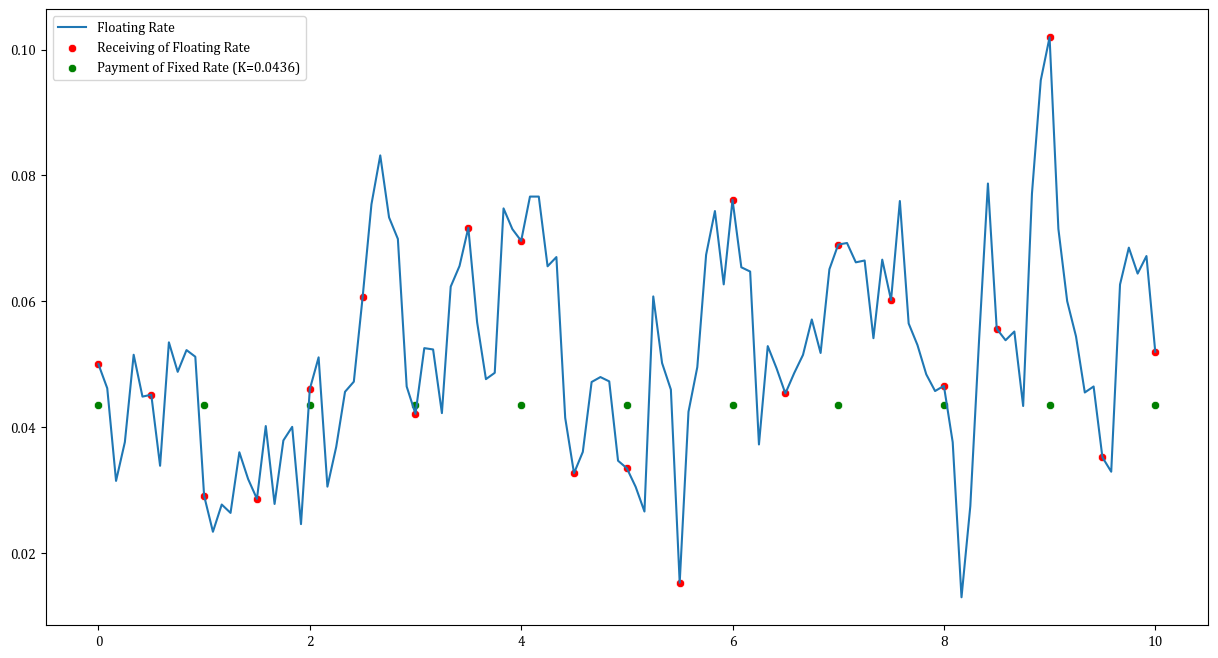

In [27]:
from products import *
from scipy import optimize
fixSchedule = np.arange(0,10+1)
floSchedule = np.arange(0,20+1)/2
time, floatRate = g2pp.create_path(1/12, 10, 1999)
# (Non analytical way to find par swap rate)
K = parSwapRate(
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule,
    time=0,
    rate=g2pp.init, 
    model=g2pp)
# K=0.04
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=floatRate, label='Floating Rate')
sns.scatterplot(x=floSchedule, y=floatRate[0::6], label='Receiving of Floating Rate', c='red')
sns.scatterplot(x=fixSchedule, y=np.repeat(K, len(fixSchedule)), label=f'Payment of Fixed Rate (K={round(K,4)})', c='green')

<Axes: >

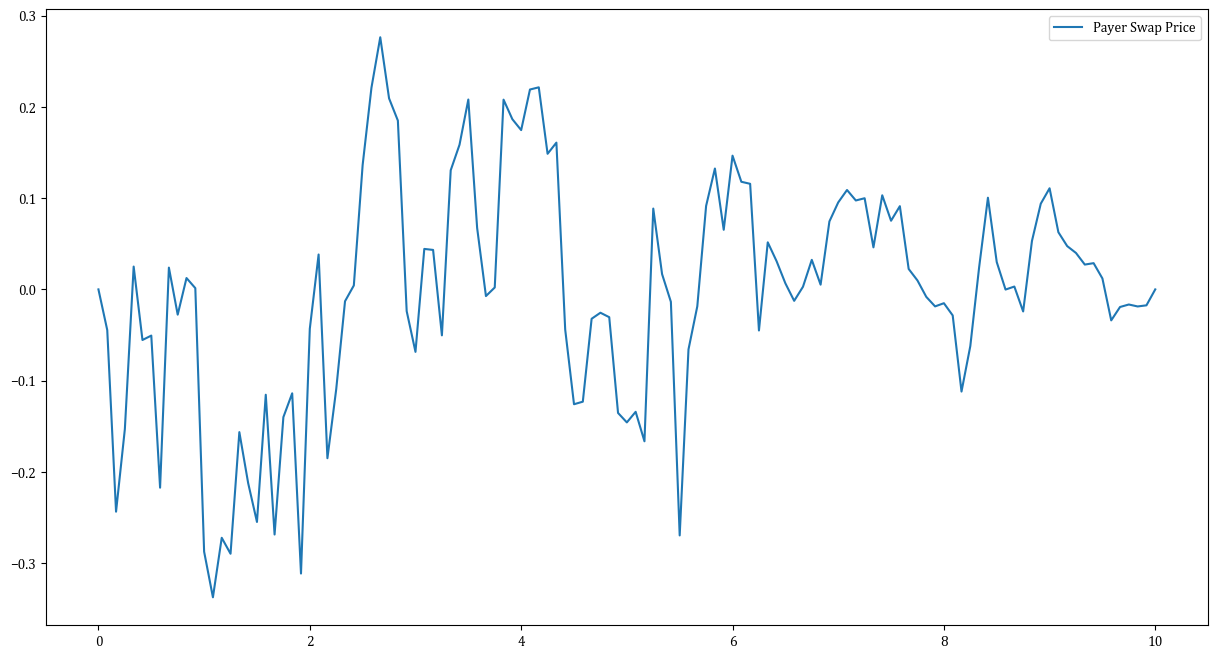

In [28]:
payerSwapPrice = [
payerSwap(
    time=x, 
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule, 
    fixedRate=K, 
    floatingRate=floatRate, 
    floatingTimeStamp=time,
    model=g2pp
)
for x in time
]
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=payerSwapPrice, label='Payer Swap Price')

<Axes: >

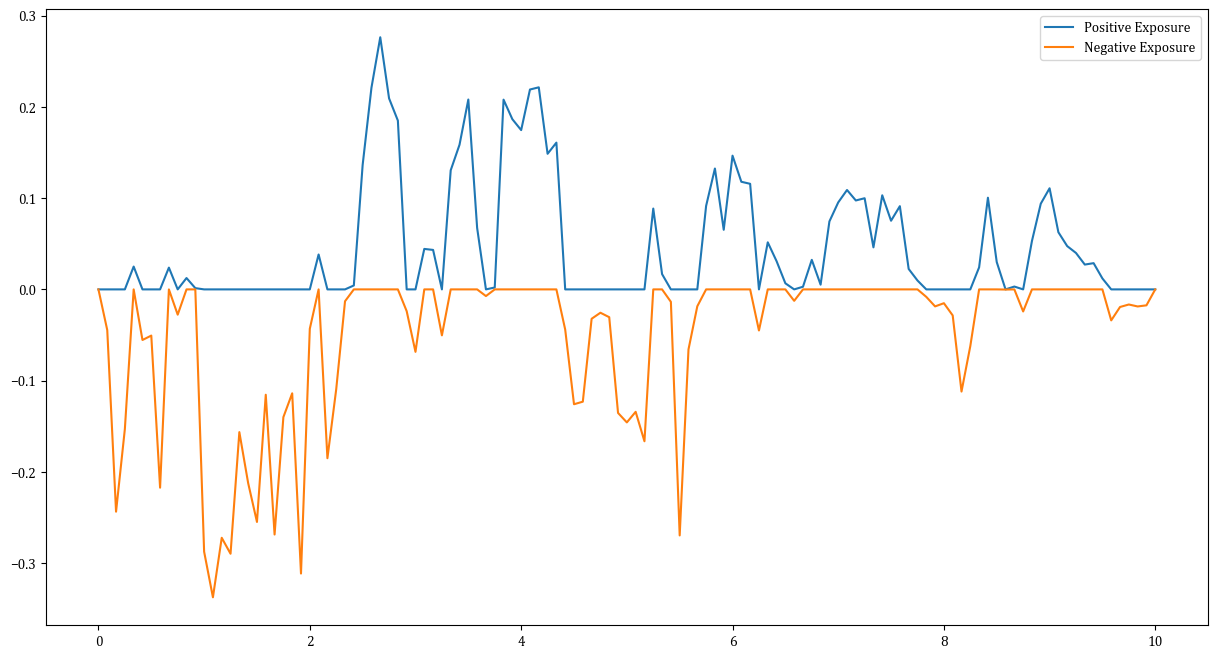

In [29]:
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=np.maximum(payerSwapPrice,0), label='Positive Exposure')
sns.lineplot(x=time, y=np.minimum(np.array(payerSwapPrice),0), label='Negative Exposure')

In [31]:
sims = np.power(10,2)
years=10
dt=1/360
EPE = np.zeros(int(years/dt+1))
ENE = np.zeros(int(years/dt+1))
K = parSwapRate(
    fixedSchedule=fixSchedule, 
    floatingSchedule=floSchedule,
    time=0,
    rate=g2pp.init, 
    model=g2pp)
time, floatRate = g2pp.create_path(stepsize=dt, duration=years, seed=0)
discounting = np.array([g2pp.ZCB(x, time=0) for x in time])
# K = 0.05
for i in range(sims):
    # print(i, end='\r')
    fixSchedule = np.arange(0,10+1)
    floSchedule = np.arange(0,20+1)/2
    time, floatRate = g2pp.create_path(stepsize=dt, duration=years, seed=i)
    payerSwapPrice=[
    payerSwap(
        time=x, 
        fixedSchedule=fixSchedule, 
        floatingSchedule=floSchedule, 
        fixedRate=K, 
        floatingRate=floatRate, 
        floatingTimeStamp=time,
        model=g2pp
    )
    for x in time
    ]

    posExposure = np.maximum(payerSwapPrice, 0) * discounting
    negExposure = np.minimum(payerSwapPrice, 0) * discounting

    EPE += posExposure
    ENE += negExposure
    print('Process: {:0.2f}%'.format(np.round((i+1)/sims*100,2)), end='\r')

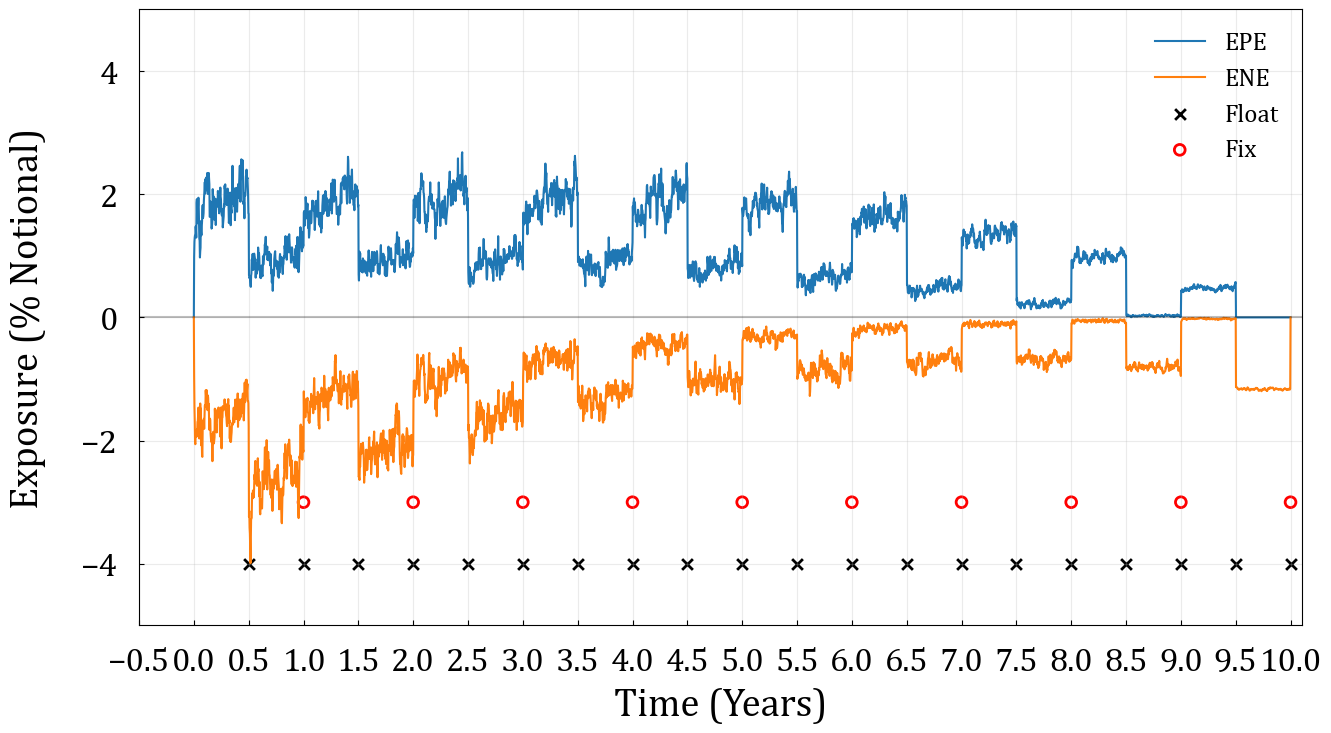

In [32]:
# import matplotlib as mpl  #Det her er haram
# mpl.rc('font',family='Cambria')
plt.rc('font',family='Cambria')
float_x = np.arange(0.5,10.5,0.5)
float_y = np.full((len(float_x),), -4)
fix_x = np.arange(1,11)
fix_y = np.full(len(fix_x), -3)

fig, ax = plt.subplots()
sns.lineplot(x=time, y=EPE/sims*100, label = 'EPE')
sns.lineplot(x=time, y=ENE/sims*100, label = 'ENE')
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
ax.set_ylim(-5,5)
ax.set_xlim(0,10.1)
ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(-0.5, 10.5, 0.5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')
